In [ ]:
! pip install transformers torch pandas tqdm sentencepiece scikit-learn seaborn

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 32.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.3 MB/s eta 0:00:00


In [2]:
from transformers import T5EncoderModel, T5Tokenizer
import torch
import pandas as pd

print("Starting to download the model and tokenizer")

# Configurar el dispositivo (GPU si está disponible, si no, CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device: ", device)

# Cargar el modelo y el tokenizador
tokenizer = T5Tokenizer.from_pretrained('Rostlab/ProstT5', do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/ProstT5").to(device)
model.float() if device.type == 'cpu' else model.half()  # Ajustar precisión

/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting to download the model and tokenizer
Device:  cuda


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5EncoderModel(
  (shared): Embedding(150, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(150, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=False)
              (dropout): Dropo

In [5]:
import gc

gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Clear CUDA cache

# Print GPU memory usage
print(" ")
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"GPU Memory Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

 
GPU Memory Allocated: 2.42 GB
GPU Memory Reserved: 2.46 GB


In [6]:
import torch
import os
import re

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def preprocess_sequence(sequence: str) -> str:
    """Preprocess a protein sequence for tokenization."""
    # Replace uncommon amino acids with 'X'
    sequence = re.sub(r"[UZOB]", "X", sequence)

    # Add spaces between characters (needed for tokenizers that expect spaced sequences)
    sequence = " ".join(list(sequence))

    # Add special prefix depending on case
    if sequence.isupper():
        return "<AA2fold> " + sequence
    else:
        return "<fold2AA> " + sequence

def process_batch(batch):
    """Encodes sequences and extracts embeddings in full precision (FP32)."""
    batch = [preprocess_sequence(seq) for seq in batch]
    ids = tokenizer.batch_encode_plus(batch, add_special_tokens=True, padding="longest", truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        embedding_repr = model(ids.input_ids, attention_mask=ids.attention_mask).last_hidden_state
        batch_embeddings = embedding_repr[:, 1:-1, :].mean(dim=1).cpu().numpy()

    del ids, embedding_repr
    torch.cuda.empty_cache()
    gc.collect()

    return batch_embeddings

def process_single_sequence_fp16(sequence):
    """Processes a single sequence using FP16 precision to save memory."""
    batch = [preprocess_sequence(sequence)]
    ids = tokenizer.batch_encode_plus(batch, add_special_tokens=True, padding="longest", truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        model.half()  # Switch to FP16
        embedding_repr = model(ids.input_ids, attention_mask=ids.attention_mask).last_hidden_state
        batch_embedding = embedding_repr[:, 1:-1, :].mean(dim=1).cpu().numpy()
        model.float()  # Switch back to FP32

    del ids, embedding_repr
    torch.cuda.empty_cache()
    gc.collect()

    return batch_embedding[0]

def get_prott5_embeddings(sequences, initial_batch_size=8):
    batch_size = initial_batch_size
    embeddings = [None] * len(sequences)  # Initialize with None to maintain order
    i = 0

    while i < len(sequences):
        print(f"Processing sequence {i+1}/{len(sequences)}")
        try:
            batch = sequences[i:i+batch_size]
            batch_embeddings = process_batch(batch)

            # Save embeddings in the correct positions
            embeddings[i:i+batch_size] = batch_embeddings
            i += batch_size  # Move to next batch

            # Restore batch size after a successful run
            if batch_size < initial_batch_size:
                print(f"✅ Restoring batch size to {initial_batch_size}.")
                batch_size = initial_batch_size

        except torch.cuda.OutOfMemoryError:
            if batch_size > 1:
                print(f"⚠️ Reducing batch size from {batch_size} to {max(1, batch_size // 2)} due to OOM.")
                batch_size = max(1, batch_size // 2)  # Reduce batch size but keep at least 1
            else:
                print(f"⚠️ Running sequence {i+1} in FP16 due to OOM.")
                torch.cuda.empty_cache()

                try:
                    embedding = process_single_sequence_fp16(sequences[i])
                    embeddings[i] = embedding  # Save even the fallback embedding
                    i += 1  # Move to next sequence

                except torch.cuda.OutOfMemoryError:
                    print(f"❌ Skipping sequence {i+1} (too large for FP16).")
                    i += 1  # Still move forward, but keep None as a placeholder

    return embeddings


In [4]:
import pandas as pd

# Simulación de un DataFrame con secuencias de proteínas
df_moondb_dataset = pd.read_csv("../datasets/moondb_dataset.csv")
df_moonprot_dataset = pd.read_csv("../datasets/moonprot_dataset.csv")

In [8]:
import numpy as np

df_moondb_dataset["embedding"] = get_prott5_embeddings(df_moondb_dataset["Amino Acid Sequence"].tolist())  # Further reduce batch size if needed
enveddings_moondb_dataset = df_moondb_dataset.dropna(subset=["embedding"])

# Save the embeddings to a file as a NumPy array
np.save("prott5_enveddings_moondb_dataset.npy", enveddings_moondb_dataset["embedding"].values)

Processing sequence 1/351
Processing sequence 9/351
Processing sequence 17/351
Processing sequence 25/351
Processing sequence 33/351
Processing sequence 41/351
Processing sequence 49/351
Processing sequence 57/351
Processing sequence 65/351
Processing sequence 73/351
Processing sequence 81/351
Processing sequence 89/351
Processing sequence 97/351
Processing sequence 105/351
Processing sequence 113/351
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 113/351
✅ Restoring batch size to 8.
Processing sequence 117/351
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 117/351
✅ Restoring batch size to 8.
Processing sequence 121/351
Processing sequence 129/351
Processing sequence 137/351
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 137/351
✅ Restoring batch size to 8.
Processing sequence 141/351
⚠️ Reducing batch size from 8 to 4 due to OOM.
Processing sequence 141/351
⚠️ Reducing batch size from 4 to 2 due to OOM.
Processing sequence 1

In [9]:
import numpy as np

df_moonprot_dataset["embedding"] = get_prott5_embeddings(df_moonprot_dataset["Amino Acid Sequence"].tolist())  # Further reduce batch size if needed
enveddings_moonprot_dataset = df_moonprot_dataset.dropna(subset=["embedding"])

# Save the embeddings to a file as a NumPy array
np.save("prott5_enveddings_moonprot_dataset.npy", enveddings_moonprot_dataset["embedding"].values)

Processing sequence 1/451
Processing sequence 9/451
Processing sequence 17/451
Processing sequence 25/451
Processing sequence 33/451
Processing sequence 41/451
Processing sequence 49/451
Processing sequence 57/451
Processing sequence 65/451
Processing sequence 73/451
Processing sequence 81/451
Processing sequence 89/451
Processing sequence 97/451
Processing sequence 105/451
Processing sequence 113/451
Processing sequence 121/451
Processing sequence 129/451
Processing sequence 137/451
Processing sequence 145/451
Processing sequence 153/451
Processing sequence 161/451
Processing sequence 169/451
Processing sequence 177/451
Processing sequence 185/451
Processing sequence 193/451
Processing sequence 201/451
Processing sequence 209/451
Processing sequence 217/451
Processing sequence 225/451
Processing sequence 233/451
Processing sequence 241/451
Processing sequence 249/451
Processing sequence 257/451
Processing sequence 265/451
Processing sequence 273/451
Processing sequence 281/451
Process

In [10]:
df_moondb_dataset.head()

,UniProt IDs,PDB ID,Gene Name,Protein Name,Amino Acid Sequence,Organism Name,Status,Protein Existence,GO BP Terms,GO CC Terms,GO MF Terms,embedding
0,Q86VP1,2M7Q; 4BMJ; 4NLH; 4Z4K; 4Z4M; 5AAS; 5YT6; 5Z7G,"{'Name': 'TAX1BP1', 'Synonyms': ['T6BP'], 'ORF...",Tax1-binding protein 1,MTSFQEVPLQTSNFAHVIFQNVAKSYLPNAHLECHYTLTPYIHPHP...,Homo sapiens (Human).,Reviewed,1,GO:0006915 - apoptotic process; GO:0006914 - a...,GO:0005776 - autophagosome; GO:0031410 - cytop...,GO:0019900 - kinase binding; GO:0046872 - meta...,"[-0.04083, -0.03029, -0.04364, -0.05737, 0.055..."
1,Q8WUM4,2OEV; 2OEW; 2OEX; 2OJQ; 2R02; 2R03; 2R05; 2XS1...,{'Name': 'PDCD6IP {ECO:0000312|HGNC:HGNC:8766}...,Programmed cell death 6-interacting protein {E...,MATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEEL...,Homo sapiens (Human).,Reviewed,1,GO:0000915 - actomyosin contractile ring assem...,GO:0042641 - actomyosin; GO:0005923 - bicellul...,GO:0048306 - calcium-dependent protein binding...,"[-0.05853, -0.01857, 0.002102, -0.006218, 0.01..."
2,Q6UWE0,NaN,{'Name': 'LRSAM1 {ECO:0000303|PubMed:20865121}...,E3 ubiquitin-protein ligase LRSAM1 {ECO:0000305},MPLFFRKRKPSEEARKRLEYQMCLAKEAGADDILDISKCELSEIPF...,Homo sapiens (Human).,Reviewed,1,GO:0006914 - autophagy; GO:0045806 - negative ...,GO:0005737 - cytoplasm; GO:0005829 - cytosol; ...,GO:0046872 - metal ion binding; GO:0061630 - u...,"[0.02003, -0.03873, -0.03123, -0.0004563, 0.01..."
3,O00499,1MUZ; 1MV0; 1MV3; 2FIC; 2RMY; 2RND; 5I22,"{'Name': 'BIN1', 'Synonyms': ['AMPHL']}",Myc box-dependent-interacting protein 1,MAEMGSKGVTAGKIASNVQKKLTRAQEKVLQKLGKADETKDEQFEQ...,Homo sapiens (Human).,Reviewed,1,GO:0007010 - cytoskeleton organization; GO:000...,GO:0015629 - actin cytoskeleton; GO:0030424 - ...,GO:0051015 - actin filament binding; GO:001982...,"[0.046, -0.05658, -0.0933, -0.05597, 0.001668,..."
4,P06744,1IAT; 1IRI; 1JIQ; 1JLH; 1NUH; 6XUH; 6XUI; 8BBH...,"{'Name': 'GPI {ECO:0000303|PubMed:2387591, ECO...",Glucose-6-phosphate isomerase {ECO:0000303|Pub...,MAALTRDPQFQKLQQWYREHRSELNLRRLFDANKDRFNHFSLTLNT...,Homo sapiens (Human).,Reviewed,1,GO:0005975 - carbohydrate metabolic process; G...,GO:0060170 - ciliary membrane; GO:0005829 - cy...,GO:0097367 - carbohydrate derivative binding; ...,"[-0.006966, -0.00777, -0.01604, 0.0404, -0.083..."


In [11]:
# Save the embeddings and amino acid sequences to a file as a dictionary
data_to_save = {
    "amino_acid_sequence": df_enveddings_clean["Amino Acid Sequence"].values,
    "embedding": df_enveddings_clean["embedding"].values
}

np.save("prott5_embeddings.npy", data_to_save)

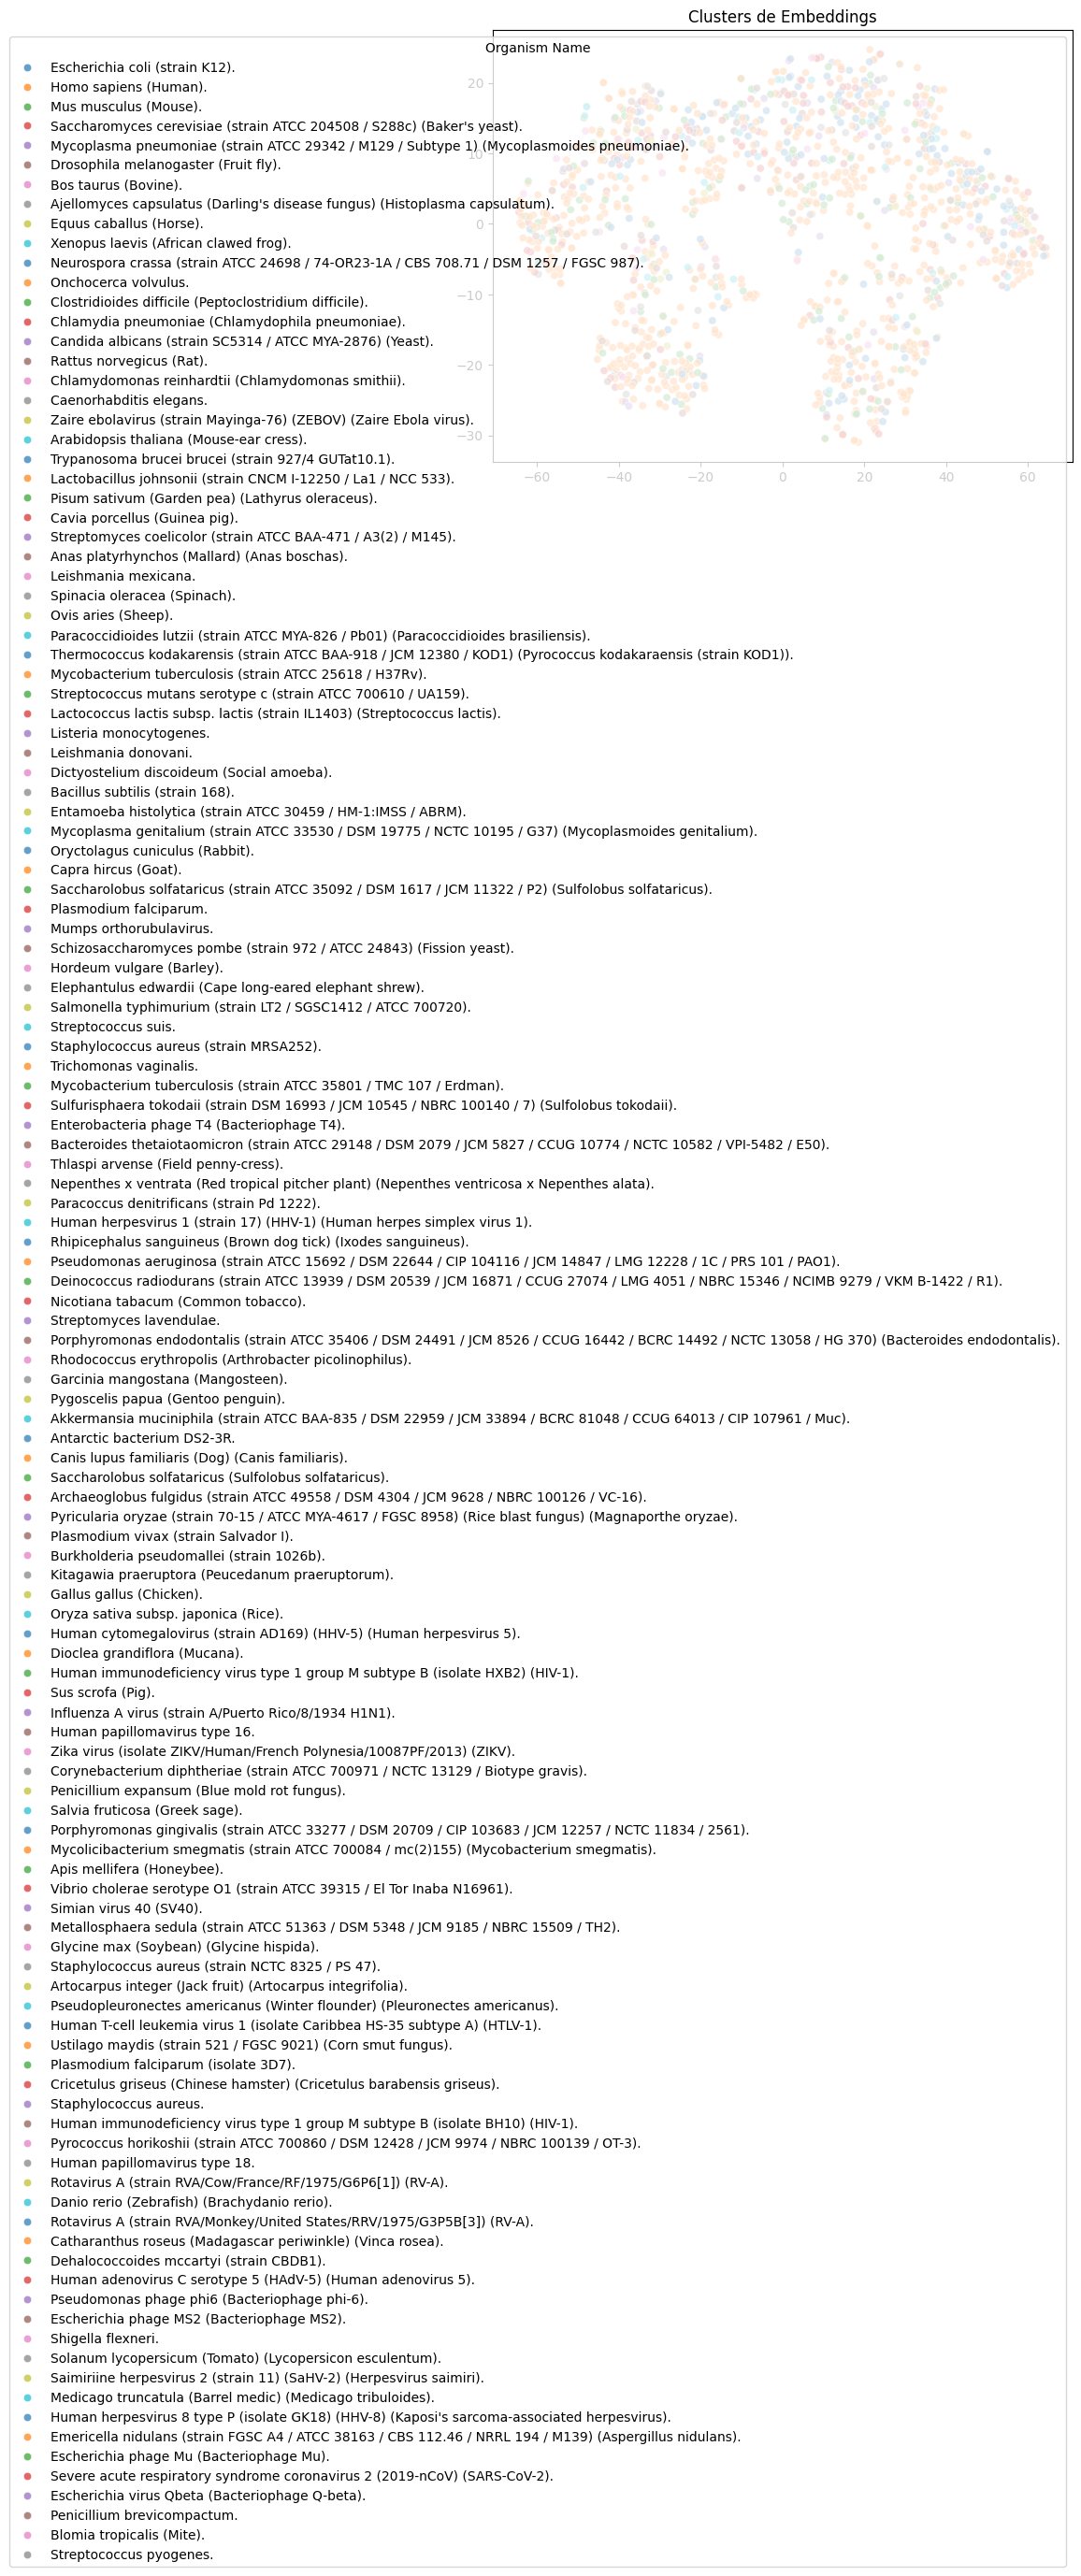

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir a matriz NumPy
X = np.vstack(df_enveddings_clean["embedding"].values)
y_labels = df_enveddings_clean["Organism Name"]

# Reducir dimensionalidad con t-SNE
X_embedded = TSNE(n_components=2, perplexity=30, random_state=2025).fit_transform(X)

# Visualizar
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_labels, palette="tab10", alpha=0.7)
plt.title("Clusters de Embeddings")
plt.show()

In [17]:
import numpy as np
import torch

# Example input sequence
input_sequence = "YOUR_AMINO_ACID_SEQUENCE_HERE"
inputs = tokenizer(input_sequence, return_tensors="pt").to(device)

# Get the model outputs including attention weights
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Extract attention weights
attention_weights = outputs.attentions  # This is a tuple of attention weights for each layer

# Convert attention weights to numpy arrays and save them
attention_weights_np = [attn.cpu().numpy() for attn in attention_weights]
np.save("prott5_attention_weights.npy", attention_weights_np)